# Fashion Dataset

The dataset consists of various images of clothing accessories, footwears, personal care items etc. The task is to classify these images into their respective article type.

The data looks as follows, 



<img src="FashionData.png">

### Un-encrypted Training

In [4]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import time

from sklearn.datasets import load_iris
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler

import numpy as np

import matplotlib.pyplot as plt

import pickle

In [31]:
#Hyper-parameters for the training
class Arguments():
    def __init__(self):
        self.batch_size = 64
        self.test_batch_size = 64
        self.epochs = 10
        self.lr = 0.01
        self.seed = 1
        self.log_interval = 1 
        self.precision_fractional = 9

args = Arguments()

_ = torch.manual_seed(args.seed)


n_train_items = 640
n_test_items = 640

In [19]:
def get_data_loaders():
    
    def to_categorical(index_tensor):
       
        #print("Index_tensor = {}".format(index_tensor))
        cat_tensor = torch.zeros(*index_tensor.shape, 10) 
        cat_tensor = cat_tensor.scatter(1, index_tensor.view(-1, 1), 1)
        return cat_tensor
    
#         l=[]
#         for i in index_tensor:
#             l.append(np.eye(3, dtype='uint8')[i])
#         return torch.tensor(l)
        
    def secret_share(tensor):
        """
        Transform to fixed precision and secret share a tensor
        """
        return (
            tensor
        )
    
    transformation = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=True, download=True, transform=transformation),
        batch_size=args.batch_size
    )
        
    test_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('../data', train=False, download=True, transform=transformation),
        batch_size=args.test_batch_size
    )
    
    encrypted_train_loader = [
        (secret_share(data), secret_share(target))
        for i, (data, target) in enumerate(train_loader)
        if i < n_train_items / args.batch_size
    ]
    
    encrypted_test_loader = [
        (secret_share(data), secret_share(target.float()))
        for i, (data, target) in enumerate(test_loader)
        if i < n_test_items / args.test_batch_size
    ]
    
    return encrypted_train_loader, encrypted_test_loader
    
    
encrypted_train_loader, encrypted_test_loader = get_data_loaders()

### Model specification

In [20]:
class Net(nn.Module):
    def __init__(self,layers):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, layers)
        self.fc2 = nn.Linear(layers, layers//2)
        self.fc3 = nn.Linear(layers//2, 10)
        
    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Training and testing functions

In [32]:
#comparison params
loss_across_epoch = []
accuracy_across_epoch = []
time_across_epoch = []


In [28]:
def train(args, model, encrypted_train_loader, optimizer, epoch,verbose):
    model.train()
    for batch_idx, (data, target) in enumerate(encrypted_train_loader): 
        start_time = time.time()
        
        optimizer.zero_grad()
        
        output = model(data)
        
       
        batch_size = output.shape[0]
        loss = loss_fn(output, target)
        #print ("The loss calculated: ", loss.item())
        loss_across_epoch.append(loss.item())
        
        loss.backward()
        
        loss_across_epoch.append(loss.item())
        
        optimizer.step()
        t = time.time() - start_time
        time_across_epoch.append(t)
        if verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tTime: {:.3f}s'.format(
                    epoch, batch_idx * args.batch_size, len(encrypted_train_loader) * args.batch_size,
                    100. * batch_idx / len(encrypted_train_loader), loss.item(), t))
            

In [29]:
def test(args, model, encrypted_test_loader,verbose):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in encrypted_test_loader:
            start_time = time.time()
            
            output = model(data)
            pred = output.argmax(dim=1)
            correct += pred.eq(target.view_as(pred)).sum()
            #print(len(private_test_loader))

 
    acc = 100. * correct.item() / (len(encrypted_test_loader) * args.test_batch_size)
    if verbose:
        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
            correct.item(), len(encrypted_test_loader)* args.test_batch_size,acc))
    return acc
    

### Start training

In [33]:
model = Net(128)

loss_fn = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=args.lr)
for epoch in range(1, args.epochs + 1):
    train(args, model, encrypted_train_loader, optimizer, epoch,True)
    acc_t = test(args, model, encrypted_test_loader,True)
    accuracy_across_epoch.append(acc_t)

Train Epoch: 1 [0/640 (0%)]	Loss: 2.330018	Time: 0.004s
Train Epoch: 1 [64/640 (10%)]	Loss: 2.321345	Time: 0.005s
Train Epoch: 1 [128/640 (20%)]	Loss: 2.347537	Time: 0.005s
Train Epoch: 1 [192/640 (30%)]	Loss: 2.304964	Time: 0.004s
Train Epoch: 1 [256/640 (40%)]	Loss: 2.299259	Time: 0.004s
Train Epoch: 1 [320/640 (50%)]	Loss: 2.283364	Time: 0.004s
Train Epoch: 1 [384/640 (60%)]	Loss: 2.293389	Time: 0.004s
Train Epoch: 1 [448/640 (70%)]	Loss: 2.278908	Time: 0.003s
Train Epoch: 1 [512/640 (80%)]	Loss: 2.296058	Time: 0.004s
Train Epoch: 1 [576/640 (90%)]	Loss: 2.277844	Time: 0.004s

Test set: Accuracy: 109/640 (17%)

Train Epoch: 2 [0/640 (0%)]	Loss: 2.261100	Time: 0.003s
Train Epoch: 2 [64/640 (10%)]	Loss: 2.232456	Time: 0.003s
Train Epoch: 2 [128/640 (20%)]	Loss: 2.254889	Time: 0.003s
Train Epoch: 2 [192/640 (30%)]	Loss: 2.240086	Time: 0.003s
Train Epoch: 2 [256/640 (40%)]	Loss: 2.222422	Time: 0.003s
Train Epoch: 2 [320/640 (50%)]	Loss: 2.224774	Time: 0.003s
Train Epoch: 2 [384/640 (60%

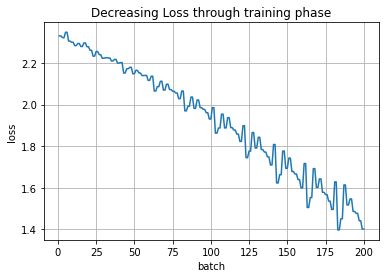

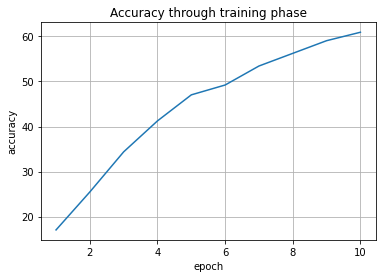

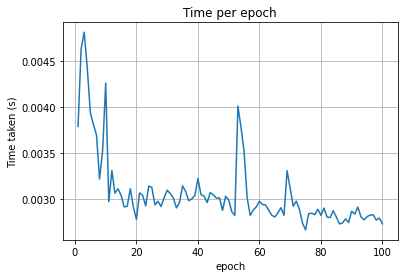

In [34]:
#print(loss_across_epoch)
cnt = np.arange(1, len(loss_across_epoch)+1, 1)

plt.plot( cnt,loss_across_epoch)

plt.xlabel('batch')
plt.ylabel('loss')
plt.title('Decreasing Loss through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(accuracy_across_epoch)+1, 1)

plt.plot( cnt,accuracy_across_epoch)

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy through training phase')
plt.grid(True)
plt.show()

cnt = np.arange(1, len(time_across_epoch)+1, 1)

plt.plot( cnt,time_across_epoch)

plt.xlabel('epoch')
plt.ylabel('Time taken (s)')
plt.title('Time per epoch')
plt.grid(True)
plt.show()

In [ ]:
for n in nn_model_neurons:
    model = Net(n)
    model = model.fix_precision().share(*workers, crypto_provider=crypto_provider, requires_grad=True)

    optimizer = optim.SGD(model.parameters(), lr=args.lr)
    optimizer = optimizer.fix_precision() 

    for epoch in range(1, args.epochs + 1):
        train(args, model, encrypted_train_loader, optimizer, epoch,False)
        acc_t = test(args, model, encrypted_test_loader,False)
        
    print('\nTraining with {} neurons: Accuracy: {:.0f}%\n'.format(n,acc_t))
    accuracy_nn_model.append(acc_t)

In [ ]:
plt.plot( nn_model_neurons,accuracy_nn_model)

plt.xlabel('neurons')
plt.ylabel('accuracy')
plt.title('Accuracy through training phase')
plt.grid(True)
plt.show()

##### We are getting over 50% accuracy using only a subset of 640 images on only 3 passes of encrypted training data. Training set and number of epochs were reduced in the interest of saving training time. We are interested to demonstrate the training on encrypted data and not focus on accuracy achieved

In [35]:
#Save metadata
with open('fashion-enc-time', 'wb') as fp:
    pickle.dump(time_across_epoch, fp)
    
with open('fashion-enc-acc', 'wb') as fp:
    pickle.dump(accuracy_across_epoch, fp)

In [ ]:
with open('fashion-enc-comp', 'wb') as fp:
    pickle.dump(accuracy_nn_model, fp)